In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score

from imblearn.over_sampling import SMOTE
from collections import Counter

# **Data & Pre-processing**

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Masters Thesis/data/attribution_data.csv')
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [ ]:
df['time'] = pd.to_datetime(df['time'])

In [ ]:
# Extract date
df['date'] = df['time'].dt.date

In [ ]:
# visit_order per cookie based on time order
df = df.sort_values(['cookie', 'time'], ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [ ]:
# Calculate the latest conversion time for each cookie
df['max_timestamp'] = df.groupby('cookie')['time'].transform('max')

# Define the time decay function
def time_decay_credit(row):
    decay_factor = 0.5
    time_diff = (row['max_timestamp'] - row['time']).days
    # return decay_factor ** time_diff
    # formula (0.5) ** (time_diff/7) = 2^(-x/7)
    return 2 ** (-time_diff/7)

# Apply the time decay function
df['time_decay'] = df.apply(time_decay_credit, axis=1)

In [ ]:
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,date,visit_order,max_timestamp,time_decay
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14 17:17:12+00:00,impression,0,0.0,Paid Search,2018-07-14,1,2018-07-14 17:17:12+00:00,1.000000
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03 12:57:25+00:00,impression,0,0.0,Paid Search,2018-07-03,1,2018-07-19 08:17:59+00:00,0.226431
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19 08:17:59+00:00,impression,0,0.0,Online Video,2018-07-19,2,2018-07-19 08:17:59+00:00,1.000000
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06 23:30:38+00:00,impression,0,0.0,Online Display,2018-07-06,1,2018-07-12 23:50:54+00:00,0.552045
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12 23:50:45+00:00,impression,0,0.0,Online Display,2018-07-12,2,2018-07-12 23:50:54+00:00,1.000000


In [ ]:
df_paths = df.groupby('cookie')[['channel', 'time_decay']].aggregate(lambda x: x.tolist()).reset_index()
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.drop(columns = ['cookie'], inplace = True)

In [ ]:
df_paths.head()

,channel,time_decay,conversion
0,"[Instagram, Online Display, Online Display, On...","[0.08411876203952225, 0.33647504815808904, 0.6...",0
1,"[Paid Search, Paid Search, Paid Search, Paid S...","[0.45286183213195336, 0.5, 1.0, 1.0, 1.0, 1.0]",0
2,"[Paid Search, Paid Search, Paid Search, Paid S...","[0.7429971445684742, 0.820335356007638, 0.9057...",0
3,[Instagram],[1.0],0
4,[Paid Search],[1.0],0


In [ ]:
total_conversions = sum(df_paths['conversion'])
print("No. of conversions: ", total_conversions)

No. of conversions:  17639


In [ ]:
# reference: https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/
def highlight_max_attribution(row, df):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = row.loc['Attributed Credit'] == df['Attributed Credit'].max()
    return ['background-color: lightgreen' if is_max else '' for v in row.index]

# **LSTM + Attention & Time decay (with class weights)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention
from tensorflow.keras.metrics import AUC

In [ ]:
# Extract sequences and labels
sequences = df_paths['channel'].tolist()
time_decays = df_paths['time_decay'].tolist()
labels = df_paths['conversion'].tolist()

# Tokenization: to convert text into sequences of integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences)
# Converts each sequence in sequences to a sequence of integers based on the tokenizer's vocabulary.
sequences_encoded = tokenizer.texts_to_sequences(sequences)

# Padding
max_len = max(len(seq) for seq in sequences_encoded)
padded_sequences = pad_sequences(sequences_encoded, maxlen=max_len, padding='post')
padded_time_decays = pad_sequences(time_decays, maxlen=max_len, padding='post', dtype='float32')

# Combine padded sequences with padded time decay
combined_input = np.array([np.column_stack((seq, dec)) for seq, dec in zip(padded_sequences, padded_time_decays)])
X = combined_input

# Convert labels to numpy array
y = np.array(labels)

# Vocabulary size: size of the tokenizer's vocabulary + 1 for the padding token.
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
combined_input.shape, padded_sequences.shape

((240108, 134, 2), (240108, 134))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [ ]:
# Model definition
input_layer = Input(shape=(max_len, 2))
lstm_layer = LSTM(64, return_sequences=True)(input_layer)

# Attention mechanism
attention_layer = Attention()([lstm_layer, lstm_layer])

# Flatten the attention output to feed into dense layers
attention_flat = tf.keras.layers.Flatten()(attention_layer)
dense_layer = Dense(32, activation='relu')(attention_flat)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

In [ ]:
# reference: https://stackoverflow.com/questions/46009619/keras-weighted-binary-crossentropy
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Train model
model.fit(X_train, y_train, epochs=5, batch_size=128, class_weight=class_weight_dict, validation_split=0.2)

Epoch 1/5
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 373s 308ms/step - accuracy: 0.6846 - auc: 0.5699 - loss: 0.6784 - val_accuracy: 0.8381 - val_auc: 0.5831 - val_loss: 0.6379
Epoch 2/5
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 368s 297ms/step - accuracy: 0.7619 - auc: 0.5758 - loss: 0.6715 - val_accuracy: 0.8140 - val_auc: 0.5816 - val_loss: 0.6234
Epoch 3/5
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 377s 293ms/step - accuracy: 0.7537 - auc: 0.5824 - loss: 0.6708 - val_accuracy: 0.8079 - val_auc: 0.5835 - val_loss: 0.6635
Epoch 4/5
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 387s 297ms/step - accuracy: 0.7671 - auc: 0.5847 - loss: 0.6733 - val_accuracy: 0.8071 - val_auc: 0.5836 - val_loss: 0.6415
Epoch 5/5
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 415s 325ms/step - accuracy: 0.7669 - auc: 0.5818 - loss: 0.6717 - val_accuracy: 0.7809 - val_auc: 0.5832 - val_loss: 0.6497


In [ ]:
model.save('/content/drive/My Drive/Masters Thesis/saved_models/lstmAttention_model-balanced-timedecay.h5')

In [ ]:
# model = tf.keras.models.load_model('/content/drive/My Drive/Masters Thesis/saved_models/lstmAttention_model-balanced-timedecay.h5', custom_objects={'Attention': Attention})

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 134, 2)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 134, 64)        │         17,152 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 134, 64)        │              0 │ lstm[0][0], lstm[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8576)           │              0 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │        274,464 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             33 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 874,949 (3.34 MB)

 Trainable params: 291,649 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 583,300 (2.23 MB)

In [ ]:
# Evaluate model
results = model.evaluate(X_test, y_test)

1501/1501 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - accuracy: 0.7789 - auc: 0.5817 - loss: 0.6511


In [ ]:
# Print all results
print(f'Loss: {round(results[0],2)}')
print(f'Accuracy: {round(results[1],2)}')
if len(results) > 2:
    print(f'AUC: {round(results[2],2)}')  # If AUC or other metrics are included

Loss: 0.65
Accuracy: 0.78
AUC: 0.59


## Assigning Attribution values

In [ ]:
model.layers[2]

<Attention name=attention, built=True>

In [ ]:
attention_model = Model(inputs=model.input, outputs=model.layers[2].output)
attention_weights = attention_model.predict(X_test)

1501/1501 ━━━━━━━━━━━━━━━━━━━━ 56s 37ms/step


In [ ]:
channel_names = [channel.title() for channel in list(tokenizer.word_index.keys())]

In [ ]:
def compute_unnormalized_attributions(X_sequences, y_labels, attention_weights, channel_names):
    # Initialize a dictionary to store total attributions and counts for each channel
    channel_attributions = {channel: 0 for channel in channel_names}
    channel_counts = {channel: 0 for channel in channel_names}

    # Process each sequence
    for i, (sequence, label) in enumerate(zip(X_sequences, y_labels)):
        if label == 1:  # Only consider sequences ending in a conversion
            seq_attention_weights = attention_weights[i]

            # Average attention weights across the sequence length
            avg_attention_weights = np.mean(np.abs(seq_attention_weights), axis=1)

            # Map the averaged attention weights to channels
            for j, channel_time_index in enumerate(sequence):
                # Extract channel index from the tuple
                channel_index = int(channel_time_index[0])
                # Ensure channel_index is a single integer
                if 0 <= channel_index < len(channel_names):
                    channel_name = channel_names[channel_index]
                    channel_attributions[channel_name] += avg_attention_weights[j]
                    channel_counts[channel_name] += 1

    # Calculate mean attributions for each channel
    mean_attributions = {channel: channel_attributions[channel] / channel_counts[channel] if channel_counts[channel] > 0 else 0
                         for channel in channel_names}

    return mean_attributions

# Compute unnormalized attributions for each channel
mean_attributions = compute_unnormalized_attributions(X_test, y_test, attention_weights, channel_names)

In [ ]:
# Convert to DataFrame for easy visualization
df_mean_attributions = pd.DataFrame(list(mean_attributions.items()), columns=['Channel', 'Mean Attribution'])
df_mean_attributions

,Channel,Mean Attribution
0,Facebook,0.003734
1,Paid Search,0.017223
2,Online Video,0.007132
3,Instagram,0.018443
4,Online Display,0.016533


In [ ]:
# Normalize attribution scores to get relative importance for channels
total_conversions = np.sum(y)
score = df_mean_attributions['Mean Attribution']/ df_mean_attributions['Mean Attribution'].sum()
channel_attribution_credit = score / score.sum() * total_conversions
channel_attribution_percentages = round(score / score.sum() * 100, 2).apply(lambda x: f"{x:.2f}%")

In [ ]:
# Create a DataFrame for presentation of channel attributions
channel_attribution_df = pd.DataFrame({
    'Channel': channel_names,
    'Attribution Score': score,
    'Attributed Credit': channel_attribution_credit,
    'Attribution Percentage': channel_attribution_percentages
})

desired_order = ['Facebook', 'Instagram', 'Online Display', 'Online Video', 'Paid Search']
channel_attribution_df['Channel'] = pd.Categorical(channel_attribution_df['Channel'], categories=desired_order, ordered=True)
channel_attribution_df = channel_attribution_df.sort_values('Channel').reset_index(drop=True)

channel_attribution_df.style.apply(highlight_max_attribution, df=channel_attribution_df, axis=1)

,Channel,Attribution Score,Attributed Credit,Attribution Percentage
0,Facebook,0.059203,1044.284218,5.92%
1,Instagram,0.292446,5158.453077,29.24%
2,Online Display,0.262164,4624.302474,26.22%
3,Online Video,0.113089,1994.768856,11.31%
4,Paid Search,0.273099,4817.191375,27.31%


# SHAP

In [ ]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.8 MB/s eta 0:00:00


In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Masters Thesis/saved_models/lstmAttention_model-balanced-timedecay.h5', custom_objects={'Attention': Attention})

In [ ]:
len(X_train), len(X_test)

(192086, 48022)

GradientExplainer: https://www.kaggle.com/code/ltsmssv/shap-for-lstm-hpccv1#GradientExplainer

In [ ]:
explainer = shap.GradientExplainer(model, X_train)

In [ ]:
shap_values = explainer.shap_values(X_test[:100])

In [ ]:
shap_values.shape

(100, 134, 2, 1)

In [ ]:
# Reshape SHAP values to be (100, 134, 2) to remove singleton dimension
shap_values_reshaped = shap_values.squeeze(axis=-1)
shap_values_reshaped.shape

(100, 134, 2)

In [ ]:
channel_names = [channel.title() for channel in list(tokenizer.word_index.keys())]

In [ ]:
explainer_testdata = X_test[:100]

In [ ]:
# Get SHAP values for the channels
shap_values_channel = shap_values_reshaped[:, :, 0]  # Shape (100, 134)

# Initialize a list to store SHAP values per channel for each sample
channel_shap_list = []

# Map SHAP values to channels
for i in range(shap_values_channel.shape[0]):  # Iterate over samples
    sample_shap_dict = {channel: 0 for channel in channel_names}
    for j in range(shap_values_channel.shape[1]):  # Iterate over channels
        channel_index = int(explainer_testdata[i, j, 0])  # Get channel index from X
        if channel_index > 0:
            channel_name = channel_names[channel_index - 1]
            sample_shap_dict[channel_name] += shap_values_channel[i, j]
    channel_shap_list.append(list(sample_shap_dict.values()))

# Convert to NumPy array for easier handling
channel_shap_array = np.array(channel_shap_list)  # Shape (100, num_channels)

# Now you have SHAP values for each channel in each sample
print(channel_shap_array.shape)  # Should print (100, num_channels)

(100, 5)


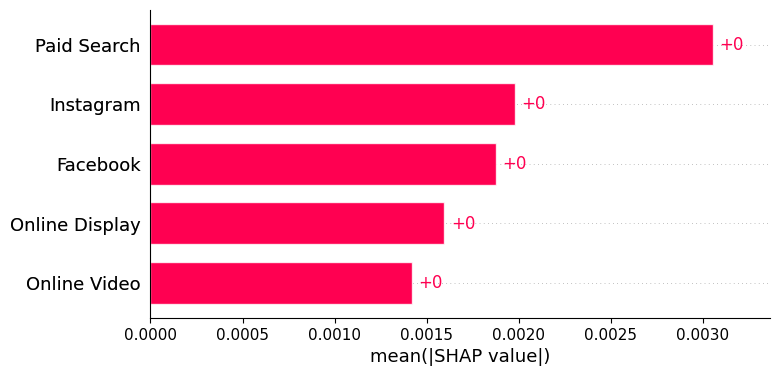

In [ ]:
shap.plots.bar(shap.Explanation(channel_shap_array, feature_names=channel_names))

In [ ]:
# Get SHAP values for time decay
shap_values_channel = shap_values_reshaped[:, :, 1]  # Shape (100, 134)

# Initialize a list to store SHAP values per channel for each sample
time_shap_list = []

# Map SHAP values to time decay
for i in range(shap_values_channel.shape[0]):   # Iterate over samples
  time_shap_list.append(np.sum(shap_values_channel[i]))

# Convert to NumPy array for easier handling
time_shap_array = np.array(time_shap_list)  # Shape (100, 1)

# Now you have SHAP values for each channel in each sample
print(time_shap_array.shape)  # Should print (100, 1)

(100,)


In [ ]:
# Join channel_shap_array and time_shap_array
combined_shap_array = np.concatenate((channel_shap_array, time_shap_array[:, np.newaxis]), axis=1)
print(combined_shap_array.shape)  # Should print (100, 6)

(100, 6)


In [ ]:
features = channel_names + ["Time Decay"]
features

['Facebook',
 'Paid Search',
 'Online Video',
 'Instagram',
 'Online Display',
 'Time Decay']

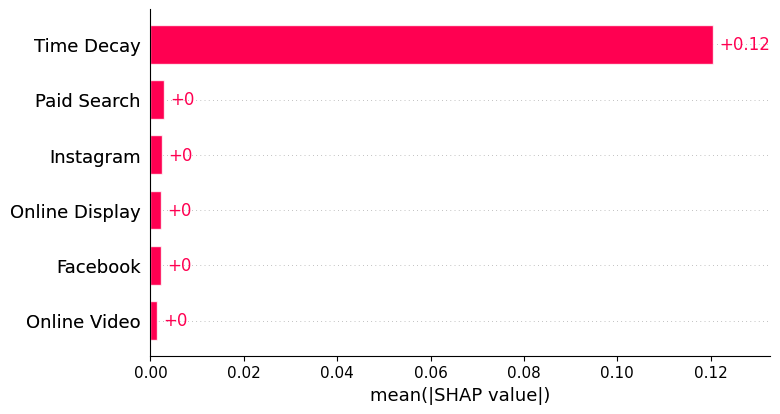

In [ ]:
shap.plots.bar(shap.Explanation(combined_shap_array, feature_names=features))

In [ ]:
# Get SHAP values for all channels together
shap_values_channel = shap_values_reshaped[:, :, 0]  # Shape (100, 134)

# Initialize a list to store SHAP values per channel for each sample
all_channels_shap_list = []

# Map SHAP values to time decay
for i in range(shap_values_channel.shape[0]):   # Iterate over samples
  all_channels_shap_list.append(np.sum(np.abs(shap_values_channel[i])))

# Convert to NumPy array for easier handling
all_channels_shap_array = np.array(all_channels_shap_list)  # Shape (100, 1)

# Now you have SHAP values for each channel in each sample
print(all_channels_shap_array.shape)  # Should print (100, 1)

(100,)


In [ ]:
# Join all_channels_shap_array and time_shap_array
combined_shap_array = np.concatenate((all_channels_shap_array[:, np.newaxis], time_shap_array[:, np.newaxis]), axis=1)
print(combined_shap_array.shape)  # Should print (100, 2)

(100, 2)


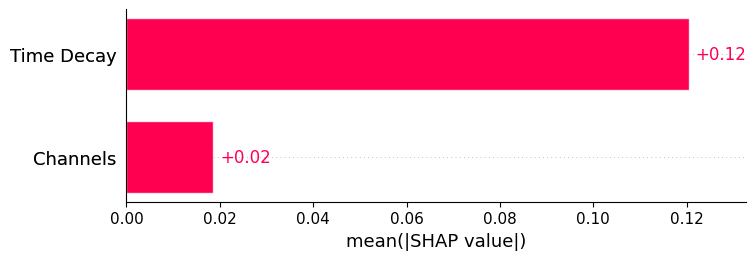

In [ ]:
shap.plots.bar(shap.Explanation(combined_shap_array, feature_names=['Channels', 'Time Decay']))

---